# ARIMA Model for Predicting BTC Returns
This project aims to forecast Bitcoin (BTC) returns using the ARIMA (AutoRegressive Integrated Moving Average) model. The ARIMA model is a time series analysis technique that combines autoregressive (AR), moving average (MA), and differencing components.


### Import necessary libraries and packages


In [1]:
import warnings
warnings.filterwarnings('ignore')
!pip install statsmodels

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit


### Download BTC-EUR data from Yahoo Finance


In [3]:
df=yf.download(tickers='BTC-EUR', start = '2021-01-1', end= '2023-05-10')
df["returns"]=df.Close.pct_change()
df.dropna(inplace=True)

[*********************100%***********************]  1 of 1 completed


- Plot the time series data of BTC returns


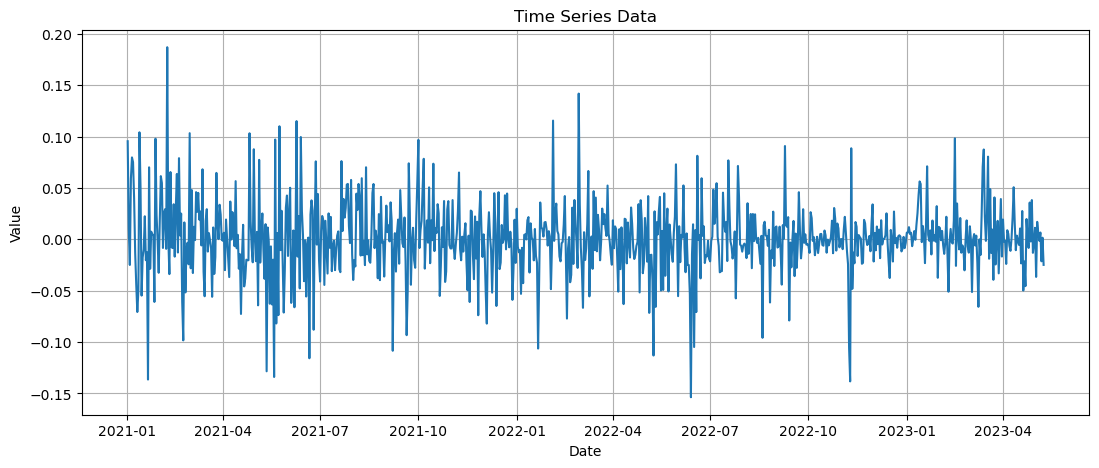

In [4]:

fig = plt.subplots(figsize=(13,5))

# Plot the time series data
plt.plot(df['returns'])
plt.xlabel('Date')
plt.grid(True)
plt.ylabel('Value')
plt.title('Time Series Data')
plt.show()


### Stationarity

ADF test (Augmented Dickey Fuller test)
- If t-value > 0.05 we need to find the order of differencing (differencing till we respect the p-value condition)
- Otherwise it will be consider stationary

In [5]:
result = adfuller(df.Close.dropna())
resultdiff = adfuller(df.returns.dropna())
print('p-value for prices', result[1])
print('p-value for returns', resultdiff[1])


p-value for prices 0.4767390679042336
p-value for returns 0.0


The price is obviouly no stationnary, howver the returns are. (Differencing order is one)

- Plot the original data and autocorrelation

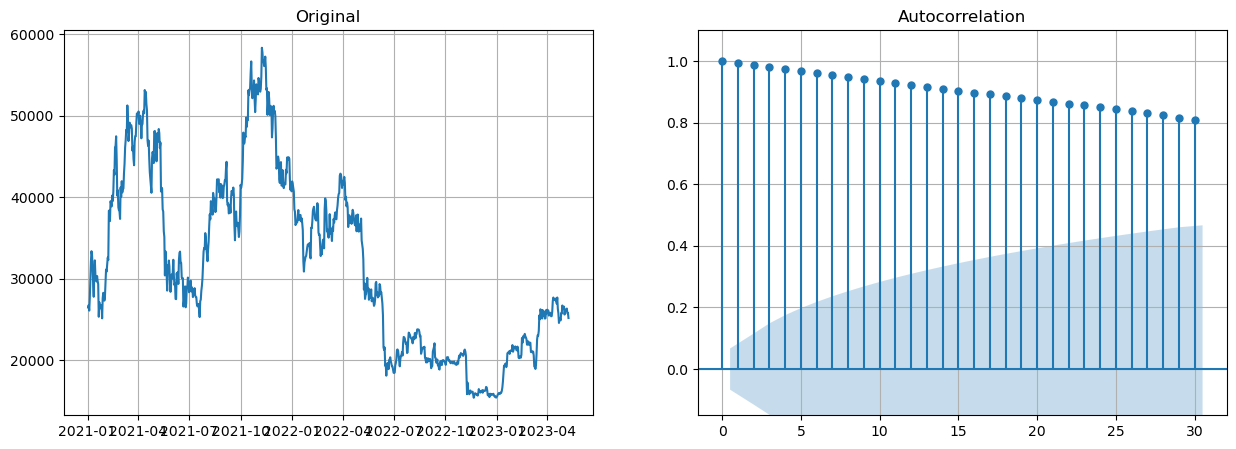

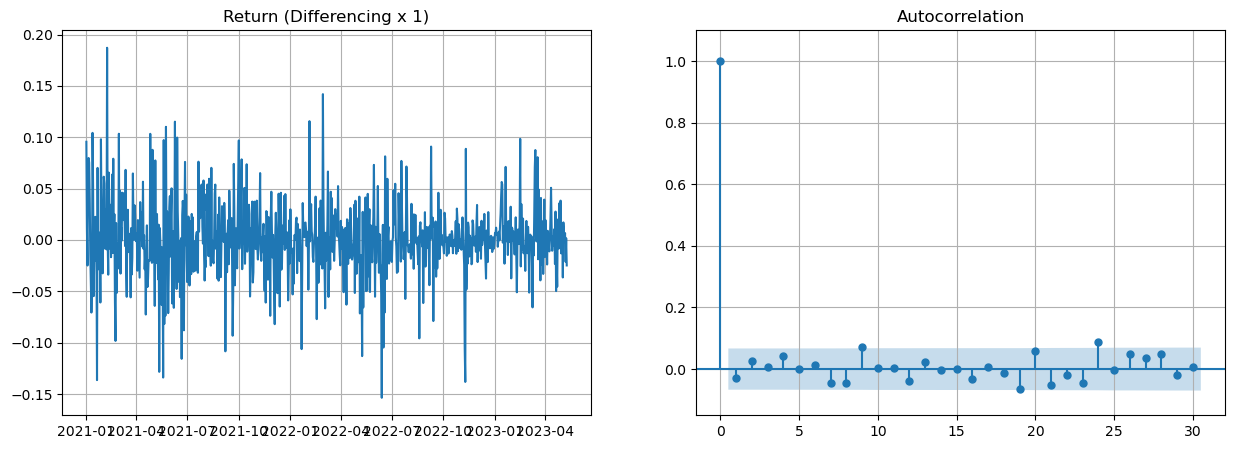

In [6]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
ax1.plot(df['Close'])
ax1.set_title("Original")
plot_acf(df['Close'],ax=ax2)
ax2.set_ylim(-0.15,1.1)
ax1.grid()
ax2.grid()
plt.show()

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
ax1.plot(df['returns'])
ax1.set_title("Return (Differencing x 1)")
plot_acf(df['returns'],ax=ax2)
ax2.set_ylim(-0.15,1.1)
ax1.grid()
ax2.grid()
plt.show()

The price is obviouly no stationnary, howver the returns are. (Differencing order is one)

### p - Parameter
- Set the parameter p (AR order) using PACF plot.
- Plot the differenced data and autocorrelation.


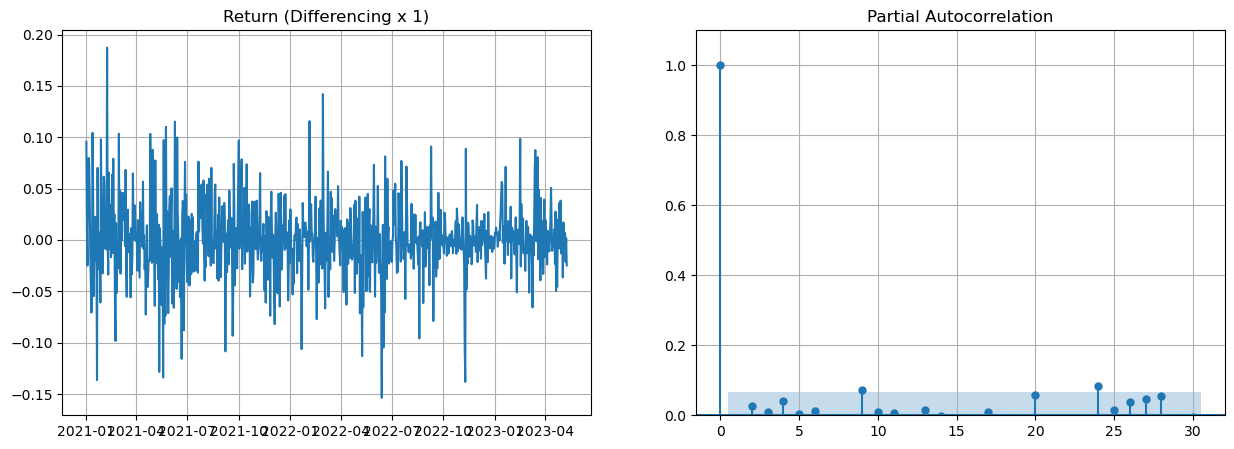

In [7]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
ax1.plot(df['returns'])
ax1.set_title("Return (Differencing x 1)")
plot_pacf(df['returns'],ax=ax2)
ax2.set_ylim(0,1.1)
ax1.grid()
ax2.grid()
plt.show()

The partial autocorrelation plot indicates that a baseline model with p=9 would be a relevant choice due to the observed significant partial autocorrelation at lag 9.

### q - Parameter
- Set the parameter q (MA order) using ACF plot


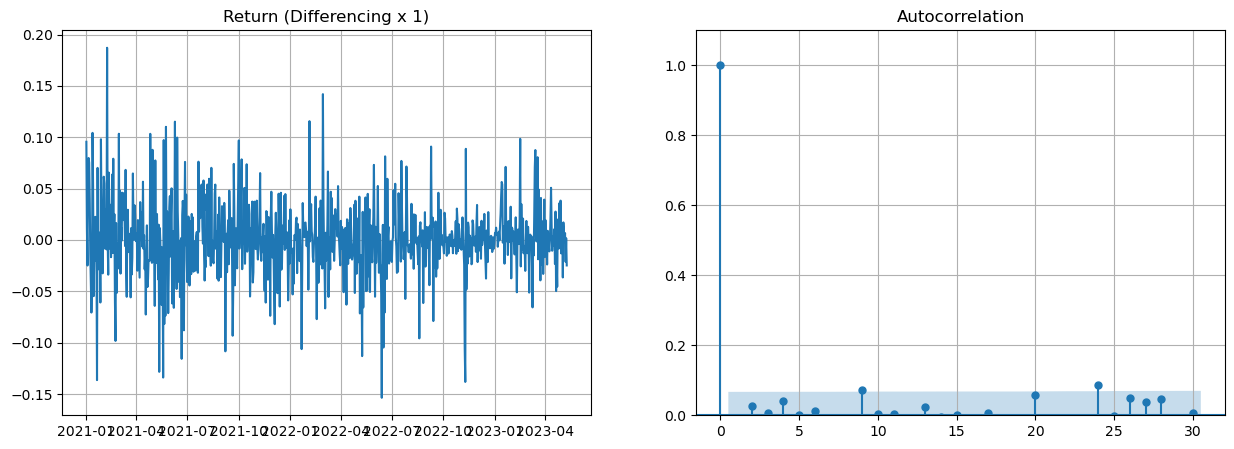

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
ax1.plot(df['returns'])
ax1.set_title("Return (Differencing x 1)")
plot_acf(df['returns'],ax=ax2)
ax2.set_ylim(0,1.1)
ax1.grid()
ax2.grid()
plt.show()

The autocorrelation plot indicates that a baseline model with q=9 would be a relevant choice due to the observed significant autocorrelation at lag 9.

### Perform train-test split

In [9]:
n=int(len(df) * 0.8)
Xtrain, Xtest =df[:n], df[n:]
Xtrain, Xtest =Xtrain[['returns']], Xtest[['returns']]

### Specify the order of the ARIMA model (p, d, q)


In [10]:
p =9   # AR order
d =1  # Integration order (differencing)
q =9  # MA order

### Create the ARIMA model


In [18]:
warnings.filterwarnings('ignore')

model = sm.tsa.ARIMA(Xtrain, order=(p, d, q))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                  686
Model:                 ARIMA(9, 1, 9)   Log Likelihood                1267.505
Date:                Sat, 27 May 2023   AIC                          -2497.010
Time:                        23:03:06   BIC                          -2410.951
Sample:                    01-02-2021   HQIC                         -2463.710
                         - 11-18-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3379      0.884     -0.382      0.702      -2.071       1.395
ar.L2         -0.4595      0.467     -0.983      0.326      -1.376       0.457
ar.L3         -0.5674      0.408     -1.391      0.164      -1.367       0.232
ar.L4          0.0166      0.486      0.034      0.973      -0.936       0.969
ar.L5         -0.1810      0.478     -0.379      0.705      -1.117       0.755
ar.L6         -0.5475      0.302     -1.811      0.070      -1.140       0.045
ar.L7          0.2296      0.447      0.514      0.607      -0.646       1.105
ar.L8         -0.1993      0.522     -0.382      0.703      -1.223       0.824
ar.L9         -0.0599      0.059     -1.010      0.312      -0.176       0.056
ma.L1         -0.7000      0.883     -0.792      0.428      -2.431       1.031
ma.L2          0.2030      0.877      0.232      0.817      -1.515       1.921
ma.L3          0.0826      0.195      0.424      0.671      -0.299       0.464
ma.L4         -0.5463      0.232     -2.355      0.019      -1.001      -0.092
ma.L5          0.2219      0.543      0.409      0.683      -0.842       1.286
ma.L6          0.3156      0.319      0.991      0.322      -0.309       0.940
ma.L7         -0.8714      0.316     -2.758      0.006      -1.491      -0.252
ma.L8          0.4949      0.858      0.577      0.564      -1.188       2.177
ma.L9         -0.1503      0.605     -0.248      0.804      -1.337       1.036
sigma2         0.0014   6.27e-05     22.847      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):               110.75
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               0.55   Skew:                            -0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [12]:
step =10

- Plot the original returns and the predicted one.

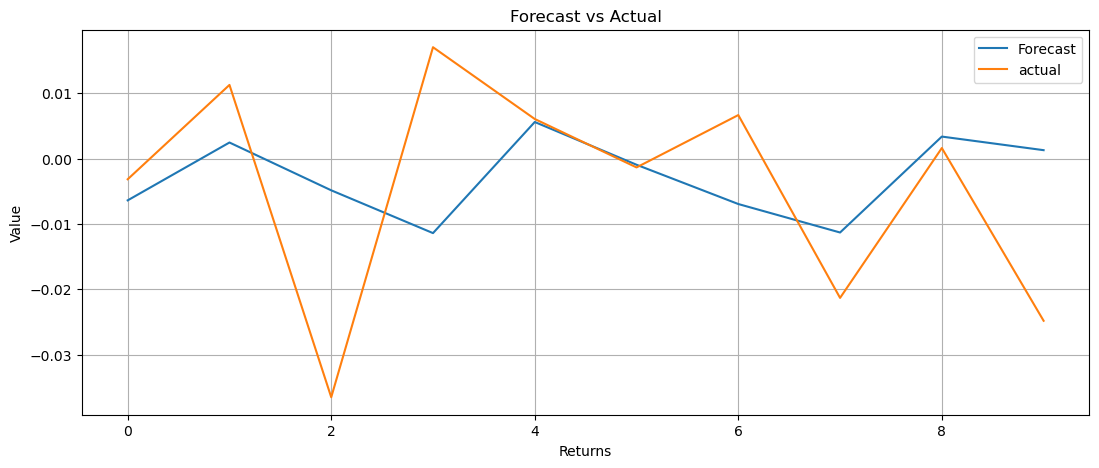

In [13]:
fig, ax= plt.subplots(figsize=(13,5))
Fc=list(results.forecast(step))
plt.plot(Fc,label="Forecast")
plt.plot(np.array(Xtest[-step:]),label="actual")
plt.title('Forecast vs Actual')
plt.legend()
plt.xlabel('Returns')
plt.ylabel('Value')
plt.grid()
plt.show()

The ARIMA Model is in reality not that useful, it is a too simple linear model. For this reason It tends to perform poorly on complexe time series as the crypto market. 

In [14]:
#mse = mean_squared_error(np.array(Xtest), np.array(forecasted_values))
#print('Mean Squared Error (MSE):', mse)

# Comparison of the predicted and actual prices

In [15]:
def return2price (value, ArrayXtest, ArrayFc):
    Price=[value]
    Fc=[value]
    for i in range(1,len(ArrayXtest)):
        Price.append(float(Price[i-1]+Price[i-1]*ArrayXtest[i]))
        Fc.append(float(Fc[i-1]+Fc[i-1]*ArrayFc[i]))
    return Price, Fc
X=return2price(24000,np.array(Xtest[-step:]),Fc)

- Plot the original price and the predicted one.

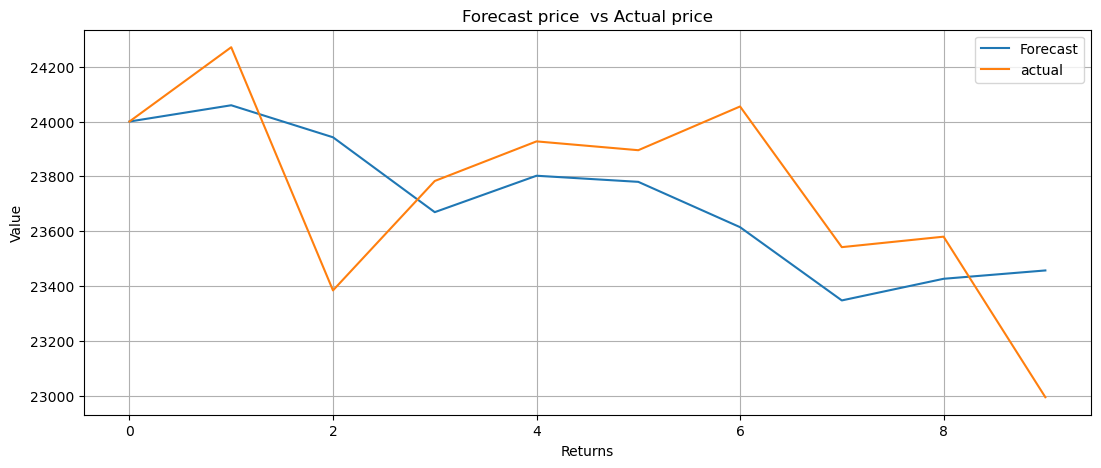

In [16]:
fig = plt.subplots(figsize=(13,5))
Fc=list(results.forecast(step))
plt.plot(X[1],label="Forecast")
plt.plot(X[0],label="actual")
plt.title('Forecast price  vs Actual price')
plt.legend()
plt.xlabel('Returns')
plt.ylabel('Value')
plt.grid()

plt.show()